# Task 2 - Generation (Re-attempt)

### Setting up dataset

New approach, I'm going to try creating a new dataset for task 2 (and also the bonus).

I'll be reusing code from Task 0 to generate the images.
I have around a 100k words, so for every other word I will have two variations.
Note: No need to run this, dataset is already created.

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import shutil
import random
from tqdm import tqdm

IMAGE_SIZE = (250, 100)
FONT_FOLDER = "fonts"
DATA_FOLDER = "dataset/task2/"
BONUS_FOLDER = "dataset/bonus/"

WORD_LIST = []

print("Loading words...")

characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

with open("others/wiki-100k.txt", "r") as f:
    words = f.readlines()
    for word in words:
        word = word.strip()
        if word[0] == "#": continue
        if not all(c in characters for c in word): continue

        WORD_LIST.append(word.strip())

print(len(WORD_LIST), "words loaded.")

FONT_FILES = os.listdir(FONT_FOLDER)
TEXT_COLORS = ["black", "red", "green", "blue", "purple", "orange", "pink", "brown"]
BONUS_TEXT_COLORS = ["black", "blue", "purple", "orange", "pink", "brown"]


def random_capitalization(word):
    return "".join([c.upper() if random.random() < 0.4 else c for c in word])


def generate_image(word, font_path, bg_color="white", text_color="black", font_size=30):
    """
        Generate an image with the given properties.
    """

    img = Image.new("RGB", IMAGE_SIZE, color=bg_color)
    draw = ImageDraw.Draw(img)

    # Try loading font
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Cannot load font {font_path}, using default")
        font = ImageFont.load_default()
    

    # Calculate text size and center it

    text_width = draw.textlength(word, font)
    text_height = font_size
    text_x = (IMAGE_SIZE[0] - text_width) // 2
    text_y = (IMAGE_SIZE[1] - text_height) // 2

    draw.text((text_x, text_y), word, font=font, fill=text_color)

    return img


def add_noise(image, noise_level):
    """
        Add noise to the image.
    """

    arr = np.array(image)
    noise = np.random.normal(0, noise_level, arr.shape)
    noisy_arr = np.clip(arr + noise, 0, 255)

    return Image.fromarray(noisy_arr.astype(np.uint8))



if os.path.exists(DATA_FOLDER):
    shutil.rmtree(DATA_FOLDER)

if (os.path.exists(BONUS_FOLDER)):
    shutil.rmtree(BONUS_FOLDER)


os.makedirs(f"{DATA_FOLDER}/train", exist_ok=True)
os.makedirs(f"{DATA_FOLDER}/val", exist_ok=True)
os.makedirs(f"{DATA_FOLDER}/test", exist_ok=True)

os.makedirs(f"{BONUS_FOLDER}/train", exist_ok=True)
os.makedirs(f"{BONUS_FOLDER}/val", exist_ok=True)
os.makedirs(f"{BONUS_FOLDER}/test", exist_ok=True)


for i, word in tqdm(enumerate(WORD_LIST)):
    partition = random.choices(population=["train", "val", "test"], weights=[0.7, 0.2, 0.1], k=1)[0]
    iter = 1 if partition != "train" else random.choice([1, 2])    # 35% chance that there will be 2 images with the same word in the training set

    for j in range(iter):
        word = random_capitalization(word)
        noise = random.uniform(0, 20)
        
        font = random.choice(os.listdir(FONT_FOLDER))
        font_path = f"{FONT_FOLDER}/{font}"
        
        text_color = random.choice(TEXT_COLORS)
        font_size = random.choice([30, 40])

        img = generate_image(word, font_path, text_color=text_color, font_size=font_size)
        img = add_noise(img, noise)

        os.makedirs(f"{DATA_FOLDER}/{partition}/{word}", exist_ok=True)
        img.save(f"{DATA_FOLDER}/{partition}/{word}/{i}{j}.png")

        bonus_text_color = random.choice(BONUS_TEXT_COLORS)
        
        bonus_img_green = generate_image(word, font_path, text_color=bonus_text_color, font_size=font_size)
        bonus_img_green = add_noise(bonus_img_green, noise)
        bonus_img_red = generate_image(word[::-1], font_path, text_color="red", font_size=font_size)
        bonus_img_red = add_noise(bonus_img_red, noise)

        os.makedirs(f"{BONUS_FOLDER}/{partition}/{word}", exist_ok=True)
        bonus_img_green.save(f"{BONUS_FOLDER}/{partition}/{word}/{i}{j}_green.png")
        bonus_img_red.save(f"{BONUS_FOLDER}/{partition}/{word}/{i}{j}_red.png")



In [2]:
!ls dataset/task2/train | wc -l
!ls dataset/task2/val | wc -l
!ls dataset/task2/test | wc -l

!find dataset/task2/train -type f -name '*.png' | wc -l
!find dataset/task2/val -type f -name '*.png' | wc -l
!find dataset/task2/test -type f -name '*.png' | wc -l

   48393
    8267
    8653
   95639
    9099
    9062


The training dataset has about 100k samples (50k words), the val dataset has 18k samples and the test dataset has 9k (no overlap, even in words).

Let's now prepare a custom dataset where we encode the labels with `<SOS>`, `<EOS>`, and `PAD` tokens.

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

class dataset(Dataset):
    def __init__(self, root_dir, char2idx, transform=None):
        """
            Initialize the dataset.
            root_dir: The root directory containing the dataset.
            char2idx: A dictionary mapping characters to indices.
            transform: A torchvision transform to apply to the images.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.char2idx = char2idx
        self.samples = []
        

        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)

            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    self.samples.append((os.path.join(label_path, file), label))
    

    def encode_label(self, label):
        """
            Encode the label string into a list of indices.
            Format: [<SOS>] + [characters...] + [<EOS>]
        """

        encoded = [self.char2idx['<SOS>']]

        for char in label:
            if char in self.char2idx:
                encoded.append(self.char2idx[char])

        encoded.append(self.char2idx['<EOS>'])

        return torch.tensor(encoded, dtype=torch.long)
    

    def __len__(self):
        return len(self.samples)
    

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_encoded = self.encode_label(label)
        return image, label_encoded


def collate_fn(data):
    """
        Pad the labels to the maximum length in the batch.
        Allows for efficient batching while training, doesn't affect variable-length recognition.
    """

    images, sequences = zip(*data)
    images = torch.stack(images, 0)
    length = [seq.size(0) for seq in sequences]
    max_length = max(length)

    padded_sequences = torch.zeros(len(sequences), max_length, dtype=torch.long)

    for i, seq in enumerate(sequences):
        padded_sequences[i, :seq.size(0)] = seq

    return images, padded_sequences, length

### Encoder Module

Now, we can define the encoder module. The encoder uses a CNN to extract feature maps from the image. The feature maps are then reshaped so that the width is the sequence length.


In [3]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        """
            Initialize the encoder model.

            Slightly different CNN architecture from the previous task, more spatial information is retained.

            Input: (batch, 3, 100, 250)
            Layer 1 output: (batch, 64, 50, 125)
            Output: (batch, 128, 25, 62)
        """

        super(Encoder, self).__init__()
            
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    

    def forward(self, x):
        features = self.cnn(x)
        batch_size, channels, H, W = features.size()
        features = features.view(batch_size, channels * H, W).permute(0, 2, 1)
        return features

### Positional Encoding

This module adds information about the position of each token into its embedding. Transformers process all tokens simultaneously, so they have no built-in notion of sequence order. The positional encoding provides a determinisitc way to add this order information.

In [4]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
            Implements the fixed positional encoding as described in
            "Attention is All You Need".

            d_model: The dimension of the embeddings.
        """

        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_len, d_model)                  # (max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)                                # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    

    def forward(self, x):
        """
        Inputs:
            x: Tensor of shape (batch, seq_len, d_model)
        Outputs:
            Tensor with positional encodings added.
        """
        
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

### Transformer Decoder Module

Decoder is responsible for converting the encoded image features into a sequence of output tokens, one time step at a time.

The final output is a sequence of predictions for each timestep.

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, encoder_dim, dropout=0.1):
        """
            Initialize a transformer-based decoder.
        
        Args:
            vocab_size: Number of tokens in the vocabulary.
            embed_dim: Dimension of the token embeddings and model.
            num_heads: Number of attention heads.
            num_layers: Number of transformer decoder layers.
            encoder_dim: Dimensionality of the encoder output.
            dropout: Dropout probability.
        """

        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
        # Token embedding and positional encoding.
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, dropout)
        
        # Project encoder output if its dimension doesn't match embed_dim.
        if encoder_dim != embed_dim:
            self.encoder_proj = nn.Linear(encoder_dim, embed_dim)
        else:
            self.encoder_proj = nn.Identity()
        
        # Define the transformer decoder layers.
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Final output projection to logits for each vocabulary token.
        self.fc_out = nn.Linear(embed_dim, vocab_size)
    

    def forward(self, encoded_captions, encoder_out):
        """
        Inputs:
            encoded_captions: (batch, tgt_seq_len) - target token indices (with <SOS> as the first token).
            encoder_out: (batch, src_seq_len, encoder_dim) - encoder features.

        Returns:
            logits: (batch, tgt_seq_len, vocab_size)
        """

        batch_size, tgt_seq_len = encoded_captions.size()
        
        # Create a causal mask so that each position in the target sequence can only attend to previous positions.
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(encoded_captions.device)
        
        # Embed target captions and add positional encodings.
        tgt = self.embedding(encoded_captions)          # (batch, tgt_seq_len, embed_dim)
        tgt = self.positional_encoding(tgt)             # (batch, tgt_seq_len, embed_dim)
        tgt = tgt.transpose(0, 1)                       # (tgt_seq_len, batch, embed_dim) required by PyTorch Transformer
        
        # Project and process encoder outputs.
        memory = self.encoder_proj(encoder_out)         # (batch, src_seq_len, embed_dim)
        memory = memory.transpose(0, 1)                 # (src_seq_len, batch, embed_dim)
        
        # Pass through transformer decoder.
        out = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        out = out.transpose(0, 1)                       # (batch, tgt_seq_len, embed_dim)
        
        # Project decoder output to vocabulary logits.
        logits = self.fc_out(out)                       # (batch, tgt_seq_len, vocab_size)
        return logits

### Putting everything together

We have all the ingredients ready, now we can start making the dish. Let's first define the general model.

In [6]:
class CaptchaModel(nn.Module):
    def __init__(self, encoder, transformer_decoder):
        """
            End-to-end captcha recognition model that uses an encoder and a transformer-based decoder.
        """

        super(CaptchaModel, self).__init__()
        self.encoder = encoder
        self.decoder = transformer_decoder
    

    def forward(self, images, captions):
        """
        Inputs:
            images: (batch, 3, 100, 250) - input images.
            captions: (batch, tgt_seq_len) - target token indices with <SOS> as the first token.
        
        Returns:
            logits: (batch, tgt_seq_len, vocab_size)
        """
        encoder_out = self.encoder(images)
        outputs = self.decoder(captions, encoder_out)
        return outputs

Now we can define a training loop, evaluate loop, and some performance metrics:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Ensure tqdm is imported for progress bars

def levenshtein_distance(seq1, seq2):
    """
        Compute the Levenshtein distance between two sequences.
    """

    m, n = len(seq1), len(seq2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i

    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
    return dp[m][n]


def decode_sequence(seq, idx2char):
    """
        Decodes a sequence of indices into a string.
        Ignores PAD tokens (index 0) and <SOS>.
        Stops decoding when encountering <EOS>.
    """

    out = []
    for idx in seq:
        if idx == 0:  # PAD token
            continue
        char = idx2char.get(idx, '')
        if char == '<SOS>':
            continue
        if char == '<EOS>':
            break
        out.append(char)
    return ''.join(out)


def compute_batch_wer(outputs, targets, idx2char):
    """
        Computes the average normalized edit distance (WER) for a batch.
        For each sample, the edit distance is computed between the decoded prediction
        and target, and normalized by the length of the target word.
    """

    _, preds = torch.max(outputs, dim=2)  # (batch, seq_len)
    total_wer = 0.0
    batch_size = preds.size(0)
    for i in range(batch_size):
        pred_seq, target_seq = preds[i].tolist(), targets[i].tolist()
        pred_word, target_word = decode_sequence(pred_seq, idx2char), decode_sequence(target_seq, idx2char)
        # Compute character-level edit distance as a proxy for WER.
        distance = levenshtein_distance(list(target_word), list(pred_word))
        sample_wer = distance / max(len(target_word), 1)  # normalized per sample
        total_wer += sample_wer
    return total_wer / batch_size if batch_size > 0 else 0.0


def compute_word_accuracy(outputs, targets, idx2char):
    """
        Computes word-level accuracy for a batch.
    """

    _, preds = torch.max(outputs, dim=2)
    batch_size = preds.size(0)
    correct = 0
    for i in range(batch_size):
        pred_seq = preds[i].tolist()
        target_seq = targets[i].tolist()
        pred_word, target_word = decode_sequence(pred_seq, idx2char), decode_sequence(target_seq, idx2char)
        if pred_word == target_word:
            correct += 1
    return correct / batch_size if batch_size > 0 else 0.0


def compute_character_accuracy(outputs, targets, idx2char):
    """
        Computes character-level accuracy for a batch.
    """

    _, preds = torch.max(outputs, dim=2)
    batch_size = preds.size(0)
    correct = 0

    for i in range(batch_size):
        pred_seq = preds[i].tolist()
        target_seq = targets[i].tolist()

        cur = 0
        wlen = 0
        for pred, target in zip(pred_seq, target_seq):
            if pred == target:
                cur += 1
            wlen += 1

        correct += cur / wlen
    
    return correct / batch_size if batch_size > 0 else 0.0


def evaluate(model, val_loader, idx2char, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu", pad_idx=0):
    model.eval() 
    total_loss = 0.0
    total_wer = 0.0
    total_accuracy = 0.0
    total_char_accuracy = 0.0

    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)  # Ignore PAD tokens.

    with torch.no_grad():
        for images, captions, _ in tqdm(val_loader, desc="Evaluating"):  
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions)
            
            # Targets: remove the <SOS> token (first token).
            targets = captions[:, 1:]
            # Exclude the last decoder time step from predictions to align with targets.
            outputs = outputs[:, :-1, :]

            # Reshape outputs and targets for loss computation.
            outputs_reshaped = outputs.reshape(-1, model.decoder.vocab_size)
            targets_reshaped = targets.contiguous().view(-1)
            
            loss = criterion(outputs_reshaped, targets_reshaped)
            total_loss += loss.item()

            batch_wer = compute_batch_wer(outputs, targets, idx2char)
            total_wer += batch_wer

            batch_accuracy = compute_word_accuracy(outputs, targets, idx2char)
            total_accuracy += batch_accuracy

            batch_char_accuracy = compute_character_accuracy(outputs, targets, idx2char)
            total_char_accuracy += batch_char_accuracy


    avg_loss = total_loss / len(val_loader)
    avg_wer = total_wer / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    avg_char_accuracy = total_char_accuracy / len(val_loader)
    return avg_loss, avg_wer, avg_accuracy, avg_char_accuracy


def train(model, train_loader, val_loader, idx2char, num_epochs=20, learning_rate=1e-4, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu", pad_idx=0):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)  # PAD token is 0.
    
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_wer_loss = 0.0

        for images, captions, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images = images.to(device)
            captions = captions.to(device)
            optimizer.zero_grad()

            outputs = model(images, captions)
            
            # Exclude the <SOS> token from targets.
            targets = captions[:, 1:]
            outputs = outputs[:, :-1, :]

            # Reshape outputs and targets for loss computation.
            outputs_reshaped = outputs.reshape(-1, model.decoder.vocab_size)
            targets_reshaped = targets.contiguous().view(-1)
            
            loss = criterion(outputs_reshaped, targets_reshaped)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            batch_wer = compute_batch_wer(outputs, targets, idx2char)
            total_wer_loss += batch_wer
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_wer = total_wer_loss / len(train_loader)
        avg_val_loss, avg_val_wer, avg_val_acc, avg_char_val_acc = evaluate(model, val_loader, idx2char, device, pad_idx=pad_idx)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}, Train WER: {avg_train_wer:.4f} | " \
              f"Val Loss: {avg_val_loss:.4f}, Val WER: {avg_val_wer:.4f}, Val Accuracy: {avg_val_acc:.4f}, Val Char Accuracy: {avg_char_val_acc:.4f}")

        # Save checkpoint if current validation loss is the best so far.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
            }
            torch.save(checkpoint, f'best_model_checkpoint_epoch_{num_epochs}.pth')
            print(f"Checkpoint saved at epoch {epoch+1} with val_loss: {avg_val_loss:.4f}")


Defining hyperparameters and putting it all together:

In [ ]:
if __name__ == "__main__":

    # Create mapping from characters to indices.
    characters = "abcdefghijklmnopqrstuvwxyz"
    char2idx = {c: idx + 1 for idx, c in enumerate(characters)}  # 0 is reserved for the PAD token.
    char2idx['<SOS>'] = len(char2idx) + 1
    char2idx['<EOS>'] = len(char2idx) + 1
    vocab_size = len(char2idx) + 1  # +1 for the PAD token at index 0

    idx2char = {idx: char for char, idx in char2idx.items()}

    transform = transforms.Compose([
        transforms.Resize((100, 250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    # Load the dataset.

    print("Loading datasets...")
    data_folder = 'dataset/task2'

    train_dataset = dataset(root_dir=f"{data_folder}/train", char2idx=char2idx, transform=transform)
    val_dataset = dataset(root_dir=f"{data_folder}/val", char2idx=char2idx, transform=transform)
    test_dataset = dataset(root_dir=f"{data_folder}/test", char2idx=char2idx, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    print("Datasets loaded.")
    print(f"Dataset sizes: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


    # Initialize the model.
    encoder = Encoder()
    transformer_decoder = TransformerDecoder(
        vocab_size=vocab_size,
        embed_dim=512,          # Embedding dimension
        num_heads=8,            # Number of attention heads
        num_layers=5,           # Number of transformer decoder layers
        encoder_dim=128 * 25,   # Encoder output dimension (channels * height from Encoder output)
        dropout=0.1             # Dropout probability
    )

    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")


    start_checkpoint = "models/best_model_checkpoint_epoch_20.pth"
    model = None

    if os.path.exists(start_checkpoint):
        print("Loading checkpoint...")
        checkpoint = torch.load(start_checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Checkpoint loaded.")
    else:
        model = CaptchaModel(encoder, transformer_decoder)
    
    train(model, train_loader, val_loader, idx2char=idx2char, num_epochs=20, learning_rate=1e-4, device=device, pad_idx=0)


### Testing the model

Now, we can use the generated model file to run check the WER on the test dataset:

In [48]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

checkpoint = torch.load(f'models/generation_complete_new-arc_new-data.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_loss, test_wer, test_acc, test_char_acc = evaluate(model, test_loader, idx2char, device=device, pad_idx=0)
print(f"Test Loss: {test_loss:.4f}, Test WER: {test_wer:.4f}, Test Accuracy: {test_acc:.4f}, Test Char Accuracy: {test_char_acc:.4f}")

Evaluating: 100%|██████████| 567/567 [00:28<00:00, 20.08it/s]

Test Loss: 0.9192, Test WER: 0.5200, Test Accuracy: 0.2420, Test Char Accuracy: 0.3938


Pretty good? Not as well as I would've hoped, but adding more epochs seems to just make the model overfit on the training data.

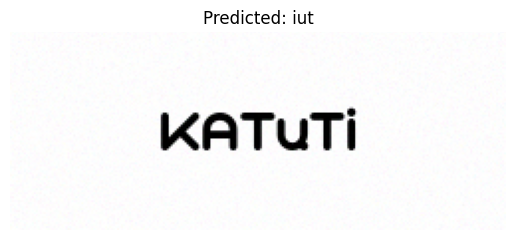

In [65]:
import random
import matplotlib.pyplot as plt

def unnormalize(tensor, mean, std):
    """
        Reverses the normalization of an image tensor.
    """

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

to_pil = transforms.ToPILImage()
image_pil = to_pil(unnormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

img_tensor = image.unsqueeze(0).to(device)

# For inference, we supply a dummy caption that starts with <SOS> token.
# The model will predict the next token and use it as input for the next timestep.

sos_idx = char2idx['<SOS>']
max_len = 5000

dummy_caption = torch.zeros(1, max_len, dtype=torch.long).to(device)
dummy_caption[0, 0] = sos_idx


model.eval()
with torch.no_grad():
    outputs = model(img_tensor, dummy_caption)
    _, preds = torch.max(outputs, dim=2)
    predicted_sequence = preds[0].tolist()


predicted_text = decode_sequence(predicted_sequence, idx2char)

plt.imshow(image_pil)
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()



## Experiments

With the model created and working, I wanted to do a few experiments.

First off, let's check what a random baseline gives us.

Let's give randomness the benefit of the doubt and assume that it knows how many tokens it has to generate every time.

In [10]:
def evaluate_random_variable_length(val_loader, idx2char, vocab_size, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"):
    """
        Evaluates loss, WER, and word accuracy using random predictions.
        For each sample, the random prediction has a length equal to the target label's length.
        Assumes that `lengths` contains the original caption lengths including <SOS>.
        Thus, the effective target length is lengths[i] - 1.
    """

    total_loss = 0.0
    total_wer = 0.0
    total_accuracy = 0.0
    total_char_acc = 0.0

    total_samples = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD tokens.

    with torch.no_grad():
        for images, captions, lengths in tqdm(val_loader):
            captions = captions.to(device)

            # Remove the <SOS> token. Note: targets is padded to a fixed max length.
            targets = captions[:, 1:]
            batch_size = captions.size(0)
            
            for i in range(batch_size):
                target_length = lengths[i] - 1
                
                # Generate a random prediction tensor for this sample of shape (target_length, vocab_size)
                random_output = torch.randn(target_length, vocab_size, device=device)
                
                # Extract the corresponding ground truth target tokens for this sample.
                target_sample = targets[i, :target_length]
                
                loss = criterion(random_output, target_sample)
                total_loss += loss.item()

                pred_indices = torch.argmax(random_output, dim=1).tolist()
                target_indices = target_sample.tolist()
                pred_word = decode_sequence(pred_indices, idx2char)
                target_word = decode_sequence(target_indices, idx2char)
                
                distance = levenshtein_distance(list(target_word), list(pred_word))
                sample_wer = distance / max(len(target_word), 1)
                total_wer += sample_wer
            
                if pred_word == target_word:
                    total_accuracy += 1

                cur = 0
                wlen = 0
                for pred, target in zip(pred_indices, target_indices):
                    if pred == target:
                        cur += 1
                    wlen += 1

                total_char_acc += cur / wlen

                total_samples += 1


    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    avg_wer = total_wer / total_samples if total_samples > 0 else 0.0
    avg_accuracy = total_accuracy / total_samples if total_samples > 0 else 0.0
    avg_char_accuracy = total_char_acc / total_samples if total_samples > 0 else 0.0

    return avg_loss, avg_wer, avg_accuracy, avg_char_accuracy


random_loss, random_wer, random_acc, random_char_acc = evaluate_random_variable_length(test_loader, idx2char, vocab_size, device=device)
print(f"Random Loss: {random_loss:.4f}, Random WER: {random_wer:.4f}, Random Accuracy: {random_acc:.4f}, Random Char Accuracy: {random_char_acc:.4f}")

100%|██████████| 567/567 [00:14<00:00, 39.33it/s]

Random Loss: 3.8359, Random WER: 1.1398, Random Accuracy: 0.0045, Random Char Accuracy: 0.0351


Wow! That's horrible!

Now, lets look at the random sequence of characters dataset.

In [71]:
EXCLUDE_FOLDER = 'dataset/exclude/samples'
exclude_dataset = dataset(root_dir=EXCLUDE_FOLDER, char2idx=char2idx, transform=transform)
exclude_loader = DataLoader(exclude_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

checkpoint = torch.load(f'models/generation_complete_new-arc_new-data.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

exclude_loss, exclude_wer, exclude_acc, exclude_char_acc = evaluate(model, exclude_loader, idx2char, device=device, pad_idx=0)
print(f"Exclude Loss: {exclude_loss:.4f}, Exclude WER: {exclude_wer:.4f}, Exclude Accuracy: {exclude_acc:.4f}")

Evaluating: 100%|██████████| 63/63 [00:03<00:00, 20.28it/s]

Exclude Loss: 4.0464, Exclude WER: 0.6855, Exclude Accuracy: 0.0020


Better results than the previous architecture!